In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from pathlib import Path
import geobr 
from pysus import SINAN 

def preparar_dataset_dengue_clima(
    path_inmet_zip: str, 
    path_ibge_csv: str,
    path_dengue_parquet: str = None, 
    ano_referencia: int = 2021
):
    print(f"\n>>> Processando Ano {ano_referencia} com Tratamento de Gaps <<<")
    
    # --- 1. DENGUE ---
    print("1. Carregando dados de Dengue...")
    df_dengue = None
    
    if path_dengue_parquet:
        try:
            df_dengue = pd.read_parquet(path_dengue_parquet)
        except FileNotFoundError:
            pass
            
    if df_dengue is None:
        try:
            p_home = Path.home() / "pysus" / f"DENGBR{str(ano_referencia)[-2:]}.parquet"
            if p_home.exists():
                df_dengue = pd.read_parquet(p_home)
        except:
            pass
            
    if df_dengue is None:
        print("   Arquivo local não encontrado. Baixando via PySUS...")
        try:
            sinan = SINAN().load()
            files = sinan.get_files(dis_code=["DENG"], year=ano_referencia)
            df_dengue = sinan.download(files) 
        except Exception as e:
            print(f"   Erro fatal ao baixar Dengue: {e}")
            return None

    # Filtros
    df_dengue = df_dengue[df_dengue["CLASSI_FIN"].astype(str).str.strip() != "5"]
    df_dengue_agg = df_dengue.groupby(["DT_NOTIFIC", "ID_MUNICIP"]).size().reset_index(name="casos_dengue")
    df_dengue_agg["ID_MUNICIP"] = df_dengue_agg["ID_MUNICIP"].astype(int)
    
    # --- 2. INMET ---
    print("2. Processando dados do INMET...")
    try:
        from reader_inmet import read_zipfile
        df_inmet = read_zipfile(path_inmet_zip)
    except ImportError:
        df_inmet = pd.read_csv(path_inmet_zip) 
        
    df_inmet['data_hora'] = pd.to_datetime(df_inmet['data_hora'])
    df_inmet['data_date'] = df_inmet['data_hora'].dt.date # Usar objeto date para reindexar
    
    # 2.1 Agregação Diária Inicial
    aggs = {
        'precipitacao': 'sum',
        'temperatura_maxima': 'max',
        'temperatura_minima': 'min',
        'temperatura_ar': 'mean',
        'umidade_relativa': 'mean',
        'vento_velocidade': 'mean',
        'latitude': 'first',
        'longitude': 'first'
    }
    cols_existentes = [c for c in aggs.keys() if c in df_inmet.columns]
    aggs_finais = {k: v for k, v in aggs.items() if k in cols_existentes}

    # Agrupa por Estação e Data
    df_inmet_diario = df_inmet.groupby(['codigo_wmo', 'data_date']).agg(aggs_finais).reset_index()

    # --- 2.2 ETAPA DE INTERPOLAÇÃO ---
    print("   Aplicando preenchimento de falhas nas estações (Gap Filling)...")
    
    # Cria um intervalo de datas completo para o ano
    all_dates = pd.date_range(start=f'{ano_referencia}-01-01', end=f'{ano_referencia}-12-31', freq='D').date
    
    lista_dfs_curados = []
    
    # Processa cada estação individualmente
    for estacao, dados in df_inmet_diario.groupby('codigo_wmo'):
        # Reindexa para garantir que todos os dias existam (cria NaNs nos dias faltantes)
        dados = dados.set_index('data_date').reindex(all_dates)
        
        # Preenche metadados (lat/lon/codigo) que ficaram NaN na reindexação
        dados['codigo_wmo'] = estacao
        dados['latitude'] = dados['latitude'].ffill().bfill()
        dados['longitude'] = dados['longitude'].ffill().bfill()
        
        # Interpolação Linear (limite de 5 dias seguidos)
        # Se choveu dia 1 e dia 3, dia 2 assume a média. Se choveu dia 1 e só dia 10, fica NaN (muito tempo sem dado)
        cols_numericas = [c for c in cols_existentes if c not in ['latitude', 'longitude']]
        dados[cols_numericas] = dados[cols_numericas].interpolate(method='linear', limit=5)
        
        dados.index.name = 'data_date'
        lista_dfs_curados.append(dados.reset_index())
    
    # Reconstrói o DF tratado
    df_inmet_full = pd.concat(lista_dfs_curados)
    df_inmet_full['DT_NOTIFIC'] = pd.to_datetime(df_inmet_full['data_date']).dt.strftime('%Y%m%d')

    # --- 3. GEO ---
    print("3. Realizando Join Espacial...")
    try:
        df_geo = geobr.read_municipal_seat(year=2010)
        df_geo['id_municip_6'] = (df_geo['code_muni'] // 10).astype(int)
        
        geo_col = 'geometry' if 'geometry' in df_geo.columns else 'geom'
        df_geo['lat_mun'] = df_geo[geo_col].apply(lambda x: x.y)
        df_geo['lon_mun'] = df_geo[geo_col].apply(lambda x: x.x)
    except Exception as e:
        print(f"Erro no geobr: {e}")
        return None

    # KDTree - Usando apenas estações que sobraram no df_inmet_full (algumas podem ter sumido se vazias)
    estacoes_validas = df_inmet_full[['codigo_wmo', 'latitude', 'longitude']].drop_duplicates().dropna()
    municipios_validos = df_geo[['id_municip_6', 'name_muni', 'lat_mun', 'lon_mun']].drop_duplicates().dropna(subset=['lat_mun', 'lon_mun'])
    
    tree = cKDTree(estacoes_validas[['latitude', 'longitude']].values)
    distancias, indices = tree.query(municipios_validos[['lat_mun', 'lon_mun']].values, k=1)
    
    municipios_validos['estacao_proxima'] = estacoes_validas.iloc[indices]['codigo_wmo'].values
    mapa_estacoes = municipios_validos[['id_municip_6', 'name_muni', 'estacao_proxima']]

    # --- 4. MERGE ---
    print("4. Unificando datasets...")
    
    df_final = pd.merge(df_dengue_agg, mapa_estacoes, left_on='ID_MUNICIP', right_on='id_municip_6', how='left')
    
    # Merge com o INMET curado
    df_final = pd.merge(
        df_final, 
        df_inmet_full, 
        left_on=['estacao_proxima', 'DT_NOTIFIC'], 
        right_on=['codigo_wmo', 'DT_NOTIFIC'], 
        how='left'
    )
    
    if 'id_municip_6' in df_final.columns:
        df_final.drop(columns=['id_municip_6'], inplace=True)
    if 'data_date' in df_final.columns:
        df_final.drop(columns=['data_date'], inplace=True)
        
    print(f"   Shape final: {df_final.shape}")
    print(f"   Linhas com NaN na temp média: {df_final['temperatura_ar'].isna().sum()}")
    df_final = df_final.sort_values('DT_NOTIFIC')
    return df_final

In [2]:
# 1. Rodar para 2021
df_2021 = preparar_dataset_dengue_clima(
    path_inmet_zip="data/2021.zip",
    path_ibge_csv="data/RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.csv",
    ano_referencia=2021
)


>>> Processando Ano 2021 com Tratamento de Gaps <<<
1. Carregando dados de Dengue...
2. Processando dados do INMET...


100%|██████████| 588/588 [00:35<00:00, 16.70it/s]


   Aplicando preenchimento de falhas nas estações (Gap Filling)...
3. Realizando Join Espacial...
4. Unificando datasets...
   Shape final: (112129, 14)
   Linhas com NaN na temp média: 24864


In [3]:
df_2021['name_muni'].unique()

array(['Rio Branco', 'Brasília', 'Campos Belos', ..., 'Congonhinhas',
       'Caçador', 'Corumbataí Do Sul'], dtype=object)

In [4]:
df_sp = df_2021[df_2021['name_muni'] == 'São Paulo']
df_sp

,DT_NOTIFIC,ID_MUNICIP,casos_dengue,name_muni,estacao_proxima,codigo_wmo,precipitacao,temperatura_maxima,temperatura_minima,temperatura_ar,umidade_relativa,vento_velocidade,latitude,longitude
350,20210106,355030,2,São Paulo,A701,A701,1.4,31.2,22.8,26.158333,59.250000,0.879167,-23.496294,-46.620088
725,20210108,355030,2,São Paulo,A701,A701,0.0,28.8,20.8,23.329167,70.916667,0.675000,-23.496294,-46.620088
946,20210110,355030,1,São Paulo,A701,A701,1.6,30.0,21.4,23.241667,78.333333,0.341667,-23.496294,-46.620088
1157,20210111,355030,3,São Paulo,A701,A701,7.2,31.0,21.6,24.370833,78.041667,0.104167,-23.496294,-46.620088
1412,20210112,355030,4,São Paulo,A701,A701,44.2,30.6,20.6,23.783333,81.083333,0.208333,-23.496294,-46.620088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110622,20211227,355030,6,São Paulo,A701,A701,3.2,26.9,20.0,22.533333,60.958333,1.704167,-23.496294,-46.620088
111006,20211228,355030,5,São Paulo,A701,A701,1.6,27.7,18.7,21.441667,71.083333,1.466667,-23.496294,-46.620088
111346,20211229,355030,9,São Paulo,A701,A701,0.0,28.9,18.4,21.937500,72.000000,1.879167,-23.496294,-46.620088
111631,20211230,355030,7,São Paulo,A701,A701,4.0,23.5,19.1,20.883333,77.833333,2.125000,-23.496294,-46.620088


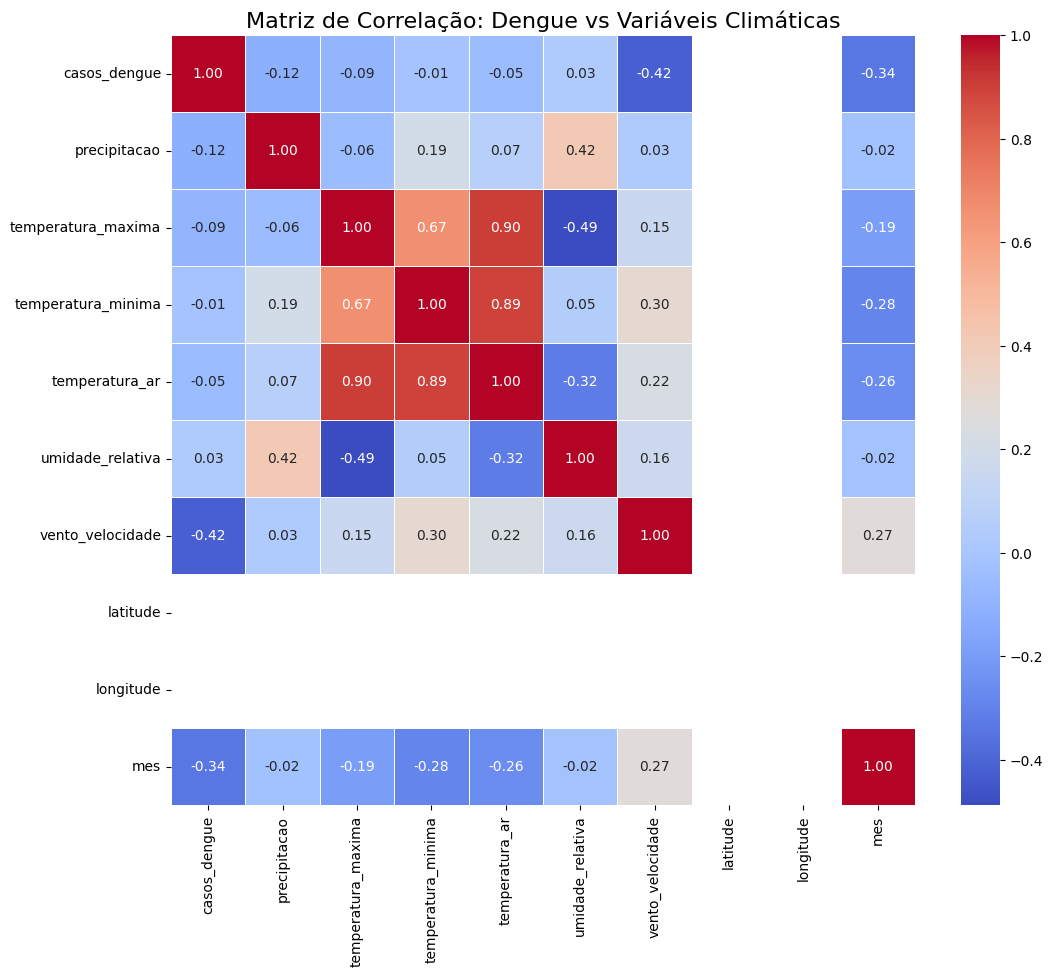

Colunas prontas para ML: ['casos_dengue', 'precipitacao', 'temperatura_maxima', 'temperatura_minima', 'temperatura_ar', 'umidade_relativa', 'vento_velocidade', 'latitude', 'longitude', 'mes']


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analisar_correlacao_ml(df):
    # Seleção de Colunas
    cols_ml = [
        'DT_NOTIFIC',
        'casos_dengue', 
        'precipitacao', 
        'temperatura_maxima', 
        'temperatura_minima', 
        'temperatura_ar', 
        'umidade_relativa', 
        'vento_velocidade',
        'latitude',
        'longitude'
    ]
    
    df_ml = df[cols_ml].copy()
    
    # 2. Engenharia de Features
    df_ml['DT_NOTIFIC'] = pd.to_datetime(df_ml['DT_NOTIFIC'])
    df_ml['mes'] = df_ml['DT_NOTIFIC'].dt.month
    
    df_ml = df_ml.drop(columns=['DT_NOTIFIC'])
    
    corr_matrix = df_ml.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix, 
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=0.5
    )
    plt.title("Matriz de Correlação: Dengue vs Variáveis Climáticas", fontsize=16)
    plt.show()
    
    return df_ml

df_para_modelo = analisar_correlacao_ml(df_sp)

print("Colunas prontas para ML:", df_para_modelo.columns.tolist())

In [6]:
def time_series_split(X, y, test_size=0.2):
    """
    Divide conjuntos de dados em treino e teste respeitando a ordem temporal (sem embaralhar).
    Funciona tanto para Pandas (DataFrame/Series) quanto para Numpy arrays.
    
    Parâmetros:
        X: Features (Dados de entrada)
        y: Target (Dados alvo)
        test_size: Porcentagem dos dados para teste (ex: 0.2 para 20%)
        
    Retorna:
        X_train, X_test, y_train, y_test
    """
    # Calcula o índice de corte
    split_index = int(len(X) * (1 - test_size))
    
    # Realiza o slice dependendo do tipo de dado (Pandas ou Numpy)
    if hasattr(X, 'iloc'): # Se for Pandas DataFrame/Series
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    else: # Se for Numpy Array ou Lista
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]
        
    return X_train, X_test, y_train, y_test

In [7]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def treinar_xgboost_dengue(df):
    print(">>> Preparando modelo (XGBoost Corrigido)...")
    
    # Prepara cópia
    if 'DT_NOTIFIC' in df.columns:
        df = df.sort_values('DT_NOTIFIC').copy()
    else:
        df = df.copy()
    
    # Feature Engineering
    cols_clima = ['precipitacao', 'temperatura_ar', 'umidade_relativa']
    for col in cols_clima:
        if col in df.columns:
            df[f'{col}_media_30d'] = df[col].rolling(30).mean()
            df[f'{col}_lag_30d'] = df[col].shift(30)

    # Lag Features
    df['casos_lag_7d'] = df['casos_dengue'].shift(7)
    df['casos_lag_14d'] = df['casos_dengue'].shift(14)
    df['casos_media_movel_7d'] = df['casos_dengue'].rolling(7).mean().shift(1)

    # Remove vazios
    df_model = df.dropna().copy()

    # Preparar dados
    # Garante features de data
    if 'mes' not in df_model.columns and 'DT_NOTIFIC' in df_model.columns:
        dates = pd.to_datetime(df_model['DT_NOTIFIC'])
        df_model['mes'] = dates.dt.month
        df_model['semana_do_ano'] = dates.dt.isocalendar().week.astype(int)

    features = [
        'mes', 'semana_do_ano',
        'precipitacao_media_30d', 'temperatura_ar_media_30d',
        'casos_lag_7d', 'casos_lag_14d', 'casos_media_movel_7d'
    ]
    features = [c for c in features if c in df_model.columns]

    split = int(len(df_model) * 0.8)
    X = df_model[features]
    y = df_model['casos_dengue']
    
    X_train, X_test, y_train, y_test = time_series_split(X, y, test_size=0.2)
    
    # Define o modelo
    model = xgb.XGBRegressor(
        objective='count:poisson',
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Resultados
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    print(f"Novo MAE: {mae:.2f}")

    # Plot
    if 'DT_NOTIFIC' in df_model.columns:
        dates_test = df_model['DT_NOTIFIC'].iloc[split:]
        plt.figure(figsize=(15, 6))
        plt.plot(dates_test, y_test, label='Real', color='blue', alpha=0.5)
        plt.plot(dates_test, preds, label='XGBoost', color='red', linestyle='--')
        plt.title('Previsão Corrigida')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    xgb.plot_importance(model, max_num_features=10)
    
    return model

>>> Preparando modelo (XGBoost Corrigido)...
Novo MAE: 2.97


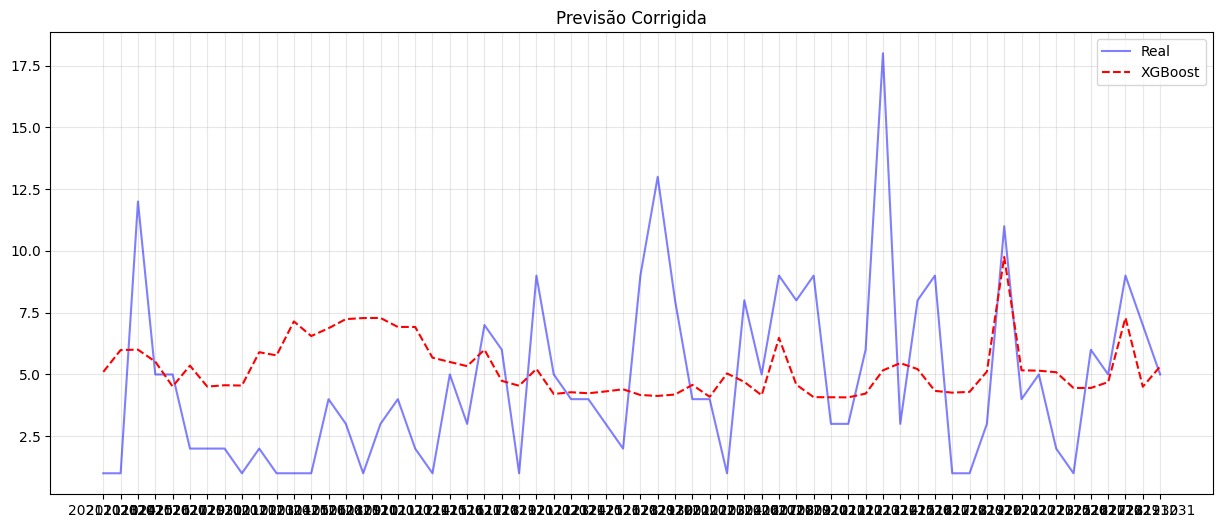

,objective,'count:poisson'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


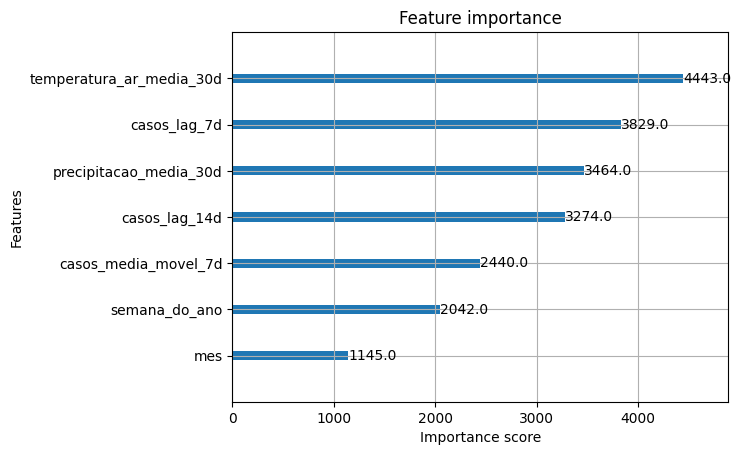

In [8]:
treinar_xgboost_dengue(df_sp)

2025-12-08 21:46:13.862904: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 21:46:13.894085: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 21:46:14.995047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


>>> 1. Preparando dados para LSTM...
   Input Shape (Amostras, Tempo, Features): (246, 30, 4)
>>> Treinando...
Epoch 1/50


E0000 00:00:1765241175.281556   42362 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765241175.309022   42362 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/Nishimura/anaconda3/envs/dengue_ml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0754 - val_loss: 0.0499
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0382 - val_loss: 0.0043
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0232 - val_loss: 0.0066
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0214 - val_loss: 0.0059
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0202 - val_loss: 0.0018
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0185 - val_loss: 0.0011
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0187 - val_loss: 0.0021
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0167 - val_loss: 0.0023
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0171 - val_loss: 0.0016
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0173 - val_loss: 0.0016
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0146 - val_loss: 8.9567e-04
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0158 - val_loss: 0.0010
Epoch 13

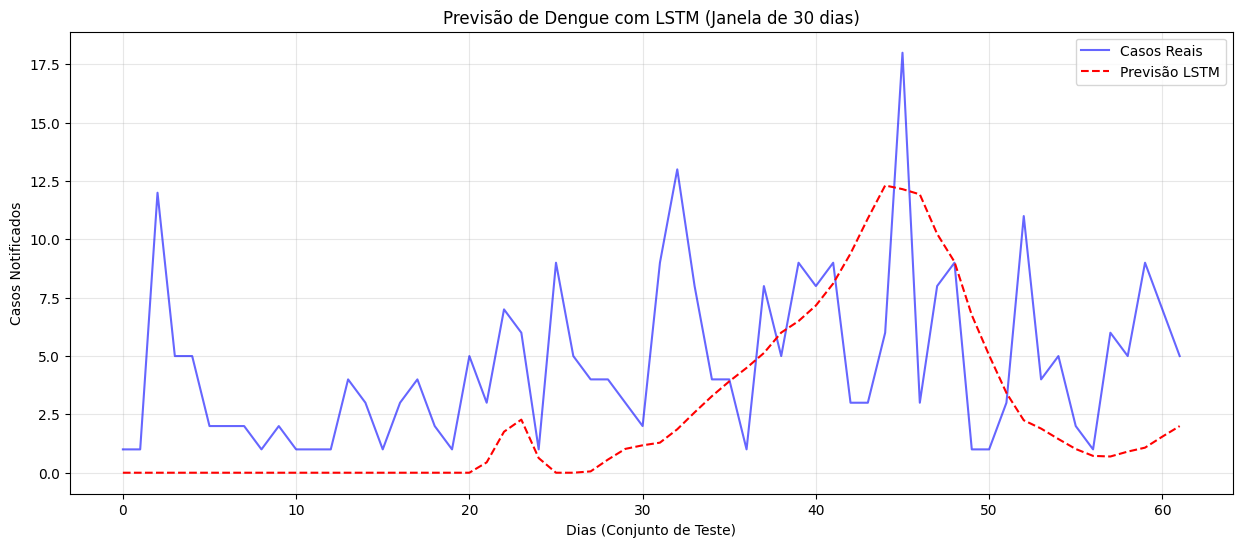

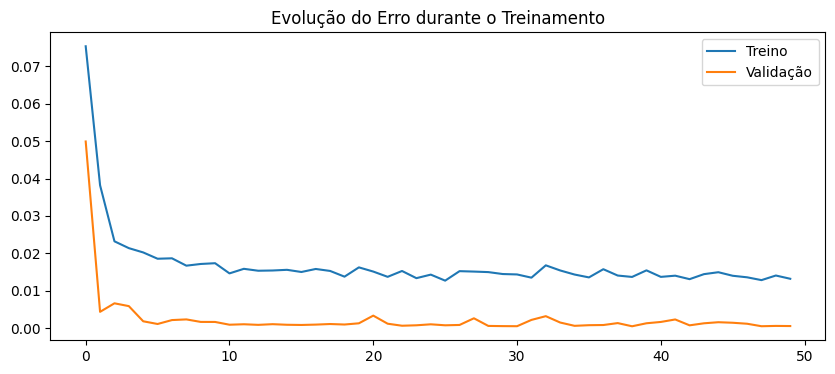

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def criar_sequencias(dados, janela_tempo):
    """
    Transforma os dados em sequências para a LSTM.
    X: Dados de t-janela até t-1
    y: Dado em t (apenas a coluna alvo)
    """
    X, y = [], []
    for i in range(len(dados) - janela_tempo):
        X.append(dados[i:(i + janela_tempo), :])
        y.append(dados[i + janela_tempo, 0])
    return np.array(X), np.array(y)

def treinar_lstm_dengue(df, janela=30):
    print(">>> 1. Preparando dados para LSTM...")
    
    # Garantir ordenação temporal
    if 'DT_NOTIFIC' in df.columns:
        df = df.sort_values('DT_NOTIFIC')
    
    # Seleção de Features
    # A primeira coluna DEVE ser o alvo (casos_dengue) para facilitar o inverso depois
    features = ['casos_dengue', 'precipitacao', 'temperatura_ar', 'umidade_relativa']
    
    # Filtra colunas que existem no df
    features = [c for c in features if c in df.columns]
    
    # Remove NaNs
    df_clean = df[features].dropna()
    dados_array = df_clean.values
    
    # Normalização
    scaler = MinMaxScaler(feature_range=(0, 1))
    dados_scaled = scaler.fit_transform(dados_array)
    
    # Criar sequências
    X, y = criar_sequencias(dados_scaled, janela)
    
    # Split Treino/Teste
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    print(f"   Input Shape (Amostras, Tempo, Features): {X_train.shape}")
    
    # definindo a rede neural
    model = Sequential()
    
    # Camada 1: LSTM
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    # Camada 2: LSTM
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Camada de Saída
    model.add(Dense(units=1))
    
    # Compilar
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    print(">>> Treinando...")
    history = model.fit(
        X_train, y_train,
        epochs=50,   
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )
    
    # Resultados
    preds_scaled = model.predict(X_test)

    dummy_test = np.zeros((len(preds_scaled), len(features)))
    dummy_test[:, 0] = preds_scaled.flatten()
    preds_real = scaler.inverse_transform(dummy_test)[:, 0]

    preds_real = np.maximum(preds_real, 0)

    dummy_y = np.zeros((len(y_test), len(features)))
    dummy_y[:, 0] = y_test
    y_real = scaler.inverse_transform(dummy_y)[:, 0]
    
    # Métricas
    mae = mean_absolute_error(y_real, preds_real)
    print(f"\n>>> MAE (Erro Médio Absoluto): {mae:.2f}")
    
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(y_real, label='Casos Reais', color='blue', alpha=0.6)
    plt.plot(preds_real, label='Previsão LSTM', color='red', linestyle='--')
    plt.title(f'Previsão de Dengue com LSTM (Janela de {janela} dias)')
    plt.xlabel('Dias (Conjunto de Teste)')
    plt.ylabel('Casos Notificados')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot de Loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Evolução do Erro durante o Treinamento')
    plt.legend()
    plt.show()
    
    return model

model_lstm = treinar_lstm_dengue(df_sp, janela=30)

/home/Nishimura/anaconda3/envs/dengue_ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing


Treino: 270 amostras | Teste: 68 amostras
>>> MAE Prophet: 17.38


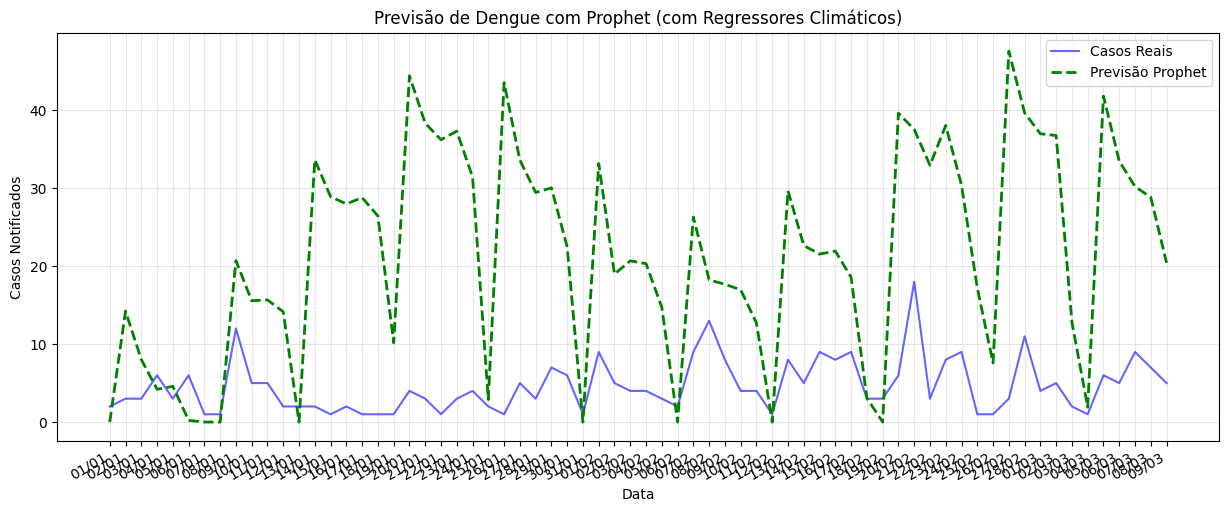

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

# 1. Preparação dos Dados
# Renomear colunas para o padrão exigido pelo Prophet (ds = data, y = alvo)
df_prophet = df_sp[['DT_NOTIFIC', 'casos_dengue', 'precipitacao', 'temperatura_ar', 'umidade_relativa']].copy()
df_prophet = df_prophet.rename(columns={'DT_NOTIFIC': 'ds', 'casos_dengue': 'y'})
df_prophet = df_prophet.sort_values('ds')

# 2. Divisão Treino/Teste (80/20)
split_idx = int(len(df_prophet) * 0.8)
df_train = df_prophet.iloc[:split_idx]
df_test = df_prophet.iloc[split_idx:]

print(f"Treino: {len(df_train)} amostras | Teste: {len(df_test)} amostras")

# 3. Configuração do Modelo
# Ativamos sazonalidades e adicionamos os regressores climáticos
model = Prophet(
    daily_seasonality=False,   # Dados diários, mas sem padrão intra-dia
    weekly_seasonality=True,   # Padrão semanal é forte em notificações
    yearly_seasonality=True    # Tenta capturar o ciclo anual da dengue
)

# Adicionar variáveis exógenas (Clima)
model.add_regressor('precipitacao')
model.add_regressor('temperatura_ar')
model.add_regressor('umidade_relativa')

# 4. Treinamento
model.fit(df_train)

# 5. Previsão
# Para prever, o Prophet precisa das datas futuras E dos valores dos regressores nessas datas
future = df_test[['ds', 'precipitacao', 'temperatura_ar', 'umidade_relativa']]
forecast = model.predict(future)

# 6. Avaliação
y_pred = np.maximum(forecast['yhat'].values, 0) # Remove valores negativos
y_true = df_test['y'].values

mae = mean_absolute_error(y_true, y_pred)
print(f">>> MAE Prophet: {mae:.2f}")

# 7. Plotagem
plt.figure(figsize=(15, 6))
plt.plot(df_test['ds'], y_true, label='Casos Reais', color='blue', alpha=0.6)
plt.plot(df_test['ds'], y_pred, label='Previsão Prophet', color='green', linestyle='--', linewidth=2)

plt.title('Previsão de Dengue com Prophet (com Regressores Climáticos)')
plt.xlabel('Data')
plt.ylabel('Casos Notificados')
plt.legend()
plt.grid(True, alpha=0.3)

# Formatação de data no eixo X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gcf().autofmt_xdate()

plt.show()

# Opcional: Ver componentes (tendência, sazonalidade)
# model.plot_components(forecast)